### Analysis of KELT-11b 

This notebook demonstrates the main features of pycheops for the analysis of as single transit of KELT-11 b observed by CHEOPS.

To run this notebook ...
* Install an up-to-date version python3 (version 3.7 or later),  e.g., https://www.anaconda.com/distribution/
* Install the latest version of pycheops using "pip install pycheops" - you may also need the "--upgrade" and/or "--user" options
* Configure your pycheops installation
```
>>> from pycheops.core import setup_config
```

* Install the DACE API (https://dace.unige.ch/pythonAPI/)
* Install tqdm - "pip install tqdm" 

#### Setup
Using pylab to import numpy, scipy and matplotlib.

Use ```%pylab notebook``` for interactive plots, but be aware that plots may not appear in the window you expect if you do not stop the plot interaction in one cell and then run plotting commands in another cell.



In [1]:
%pylab inline
import pycheops

Populating the interactive namespace from numpy and matplotlib


### Properties of KELT-11b
From TOI664.01O-cbTEC-SPOC-S09-S09-PN1.pdf on [ExoFOP](https://exofop.ipac.caltech.edu/tess/target.php?id=55092869)


Light curve for a planet of radius $R_p$ transiting a star of radius $R_s$ with impact parameter $b$ is calculated using the power-2 limb-darkening law, 
$$I_{\lambda}(\mu) = 1 - c(1 - \mu^{\alpha}),$$
and is described by the following parameters.

- T_0:   time of mid-transit
- P:     orbital period
- D:     depth, $(R_p/R_s)^2 = k^2$
- W:     width, $(R_s/a)\sqrt{(1+k)^2 - b^2}/\pi$
- b:     impact parameter, $a\cos(i)/R_s$
- c:     flux scaling factor
- f_c:   $\sqrt{e}\cos(\omega)$
- f_s:   $\sqrt{e}\sin(\omega)$
- h_1:   $I_{\lambda}(0.5) = 1 - c(1-2^{-\alpha})$
- h_2:   $I_{\lambda}(0.5) - I_{\lambda}(0) = c\cdot2^{-\alpha}$


See `help(pycheops.models.TransitModel)` for more information on the transit model.

For a circular orbit, the parameter W is the transit duration in phase units (not true for eccentric orbits).

In [2]:
P_TESS = 4.73609  # days
b_TESS = 0.43
k_TESS = 0.0461
aR_TESS = 4.90   # a/R_star

D_TESS = k_TESS**2
W_TESS = sqrt((1+k_TESS)**2 - b_TESS**2)/pi/aR_TESS

### Load the dataset and select an aperture size for the light curve data
If the data are not already in your pycheops cache directory then pycheops will attempt to downloaded them from DACE (assuming you have setup your access correctly).

The data reduction pipeline (DRP) report is shown when you download the report. To view the report again at a later time you can use the command `dataset.view_report()`

If you have obtained the dataset from elsewhere (e.g., from the plone) you must first save the file with the correct name in your pycheops cache directory, e.g., `~/pycheops_data/CH_PR300024_TG000101_V0100.tgz`.

The output from `dataset.get_lightcurve` is the numpy arrays time, flux and flux_err. We do not need these yet so we send the output to a variable "_".

In [3]:
dataset = pycheops.Dataset('CH_PR300024_TG000101_V0100')
_ = dataset.get_lightcurve(aperture='OPTIMAL')


Found archive tgzfile /Users/pflm/pycheops_data/CH_PR300024_TG000101_V0100.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 V magnitude : 8.04 +- 0.03
Light curve data loaded from  /Users/pflm/pycheops_data/CH_PR300024_TG000101_V0100-OPTIMAL.fits
Time stored relative to BJD = 2458918
Aperture radius used = 32 arcsec
Light curve corrected for flux from background stars
Mean counts = 39766790.0
Median counts = 39783104.8
RMS counts = 81033.1 [2037 ppm]
Median standard error = 6363.6 [160 ppm]
Mean contamination = 31.0 ppm


#### View animation of the data cube
This is an important step in order to understand the instrumental effects that may be present in your data. This takes some time.

Subarray data loaded from  /Users/pflm/pycheops_data/CH_PR300024_TG000101_V0100-SubArray.fits


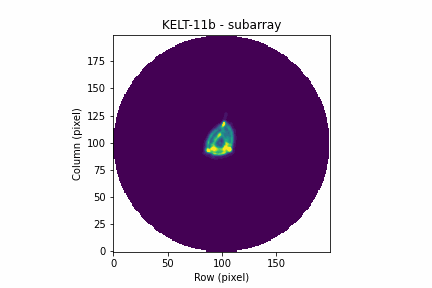

Subarray is saved in the current directory as KELT-11b-subarray.gif


In [4]:
dataset.animate_frames(vmax=0.5)

##### dataset.lc

The items in the dictionary dataset.lc are
- time = BJD-dataset.bjd_ref
- flux = observed flux scaled by its median value 
- flux_err - standard error on flux
- bjd_ref - BJD at the start of the day of observations
- table - astropy table created from binary table stored in the FITS file
- xoff, yoff - offset from nominal target location to measured flux centroid
- contam - fraction of measured flux due to contamination of aperture by other stars
- centroid_x, centroid_y - measured flux centroid position (pixels)
- roll_angle - computed mean roll angle of the CCD
- aperture - aperture radius in pixels

In [5]:
dataset.lc.keys()

dict_keys(['time', 'flux', 'flux_err', 'bjd_ref', 'table', 'header', 'xoff', 'yoff', 'bg', 'contam', 'centroid_x', 'centroid_y', 'roll_angle', 'aperture'])

##### Outlier rejection

An initial cut for obvious outliers is applied here. Data points with discrepant fluxes are rejected from all the arrays in dataset.lc _except_ `lc['table']`.  The output of the function is the clipped arrays time, flux, and flux_err.

In [6]:
time,flux,flux_err = dataset.clip_outliers(verbose=True);


Rejected 11 points more than 5.0 x MAD = 999 ppm from the median


##### Make a plot of the data "by-hand"

The plot shows a well-defined transit with a depth of about 0.2% and some little "spikes" that seem to occur regularly - we will deal with these below.

Text(0.5, 1.0, 'KELT-11b')

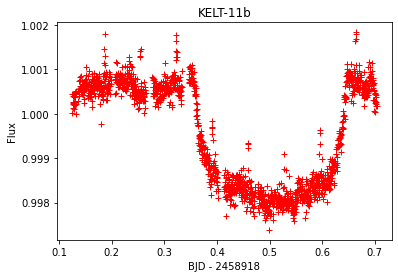

In [7]:
plot(time,flux,'r+') # matplotlib
bjd_ref = dataset.bjd_ref
xlabel(f'BJD - {bjd_ref}') # example of python f-string formatting
ylabel('Flux')
title(dataset.target)

##### Plot of flux against roll-angle
Many of the instrumental artefacts in the CHEOPS light curves are associated with the spacecraft roll angle. In this case we can see the the "spikes" occur near a roll angle of 340 degrees.

Note the use of a temporary variable `t` that "points" to the object we are using in the plot command. 


(0.0, 360.0)

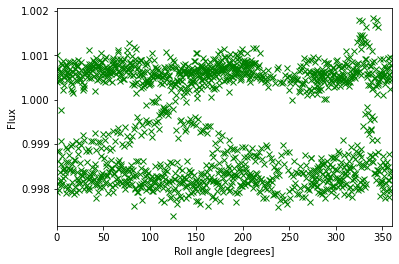

In [8]:
t = dataset.lc
plot(t['roll_angle'],t['flux'],'gx')   # plot with green crosses, just for a change
xlabel('Roll angle [degrees]')
ylabel('Flux')
xlim(0,360)

##### Plot of contamination against roll-angle

Notice in the previous cell that the output from the last command is printed to screen - the semi-colon at the end of the last command here avoids this little issue.

The contamination in this case is a small fraction of the total flux.

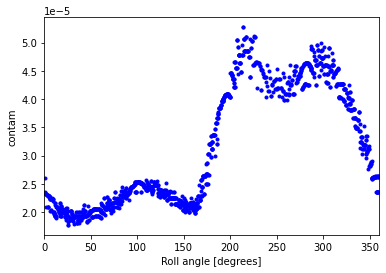

In [9]:
plot(t['roll_angle'],t['contam'],'bo',ms=3)  # blue dots, marker size =3
xlabel('Roll angle [degrees]')
ylabel('contam')
xlim(0,360);

#### Just as an illustration, mask data with roll angle 210-230$^{\circ}$
 It would be more sensible to mask out the spikes, but we will show a better way to deal with these below. 
 
 As with clip_outliers, all the internal arrays _except_ `lc['table']` are masked.

In [10]:
mask = abs(dataset.lc['roll_angle']-220) < 10
time,flux,flux_err = dataset.mask_data(mask)


Masked 62 points


#### Stellar data
Properties of the star such as Teff and log g are taken from SWEET-Cat. The SWEET-Cat catalogue is downloaded automatically if it is not in your pycheops cache folder, or if the cached version is more than a day old.

The values of Teff, logg and \[Fe/H\] are used to estimate the limb-darkening parameters of the star and the mean stellar density $\rho_{\star}$.

In [11]:
star = pycheops.StarProperties(dataset.target)
print(star)

Identifier : KELT-11b
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5370 +/-  50 K   [SWEET-Cat]
log g :  3.73 +/- 0.04    [SWEET-Cat]
[M/H] : +0.18 +/- 0.07    [SWEET-Cat]
log rho : -1.17 +/- 0.08  (solar units)
h_1 : 0.715 +/- 0.011     [Stagger]
h_2 : 0.442 +/- 0.050     [Stagger]



#### Least squares fit
The dataset method lmfit_transit uses the Levenberg-Marquardt method implemented in [lmfit](https://lmfit.github.io/lmfit-py/index.html) to find a least-squares best fit for a transit model calculated using the [qpower2](https://ui.adsabs.harvard.edu/abs/2019A%26A...622A..33M/abstract) algorithm.

Parameter values can be specified in various ways
- Fixed value, e.g., P=1.234
- Free parameter with uniform prior interval specified as a 2-tuple, e.g., dfdx=(-1,1). The initial value is taken as the the mid-point of the allowed interval.
- Free parameter with uniform prior interval and initial value specified as a 3-tuple, e.g., (0.1, 0.2, 1)
- Free parameter with a Gaussian prior specified as a [ufloat](https://pythonhosted.org/uncertainties/), e.g., ufloat(0,1). 
- as an lmfit Parameter, e.g., "lmfit.Parameter(value=0.01,min=0.001,max=0.1,vary=True)"


To enable decorrelation against a parameter, specifiy it as a free parameter, e.g., dfdbg=(0,1). The decorrelation parameters that are available can be found using `help(pycheops.models.FactorModel)`

Decorrelation is done against is a scaled version of the quantity specified with a range of either (-1,1) or, for strictly positive quantities, (0,1). This means the coefficients dfdx, dfdy, etc.
correspond to the amplitude of the flux variation due to the correlation with the relevant parameter.

The output from lmfit_transit() is an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) object.


In [12]:
# From Pepper et al., 2017
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
ecosw = ufloat(-0.004,0.050)
esinw = ufloat(0.031,0.055)
ecc = usqrt(ecosw**2+esinw**2)
f_s = esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
f_c = ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)

#### Initial fit - no decorrelation
We will use this residuals from this fit to calculate priors on the parameters of the decorrelation model.

In [13]:
lmfit0 = dataset.lmfit_transit(T_0 = (0.475,0.525), P=4.73609, 
                      D=(D_TESS/4, D_TESS, D_TESS*4),
                      W=(W_TESS/4, W_TESS, W_TESS*4),
                      b=(0,b_TESS,1),f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2.n,
                      logrhoprior=star.logrho)

#### Plots of least-squares fit 

- flux values are light blue points
- binned flux values are dark blue error bars
- transit model is the green line
- transit model + trends is the brown line 

Note the ";" at the end of the plot command to stop the plot appearing twice. Alternatively, you can put the output of the plot command (which is a [matplotlib Figure](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure) object) into a variable. This can be used later to save the plot to a file, for example.

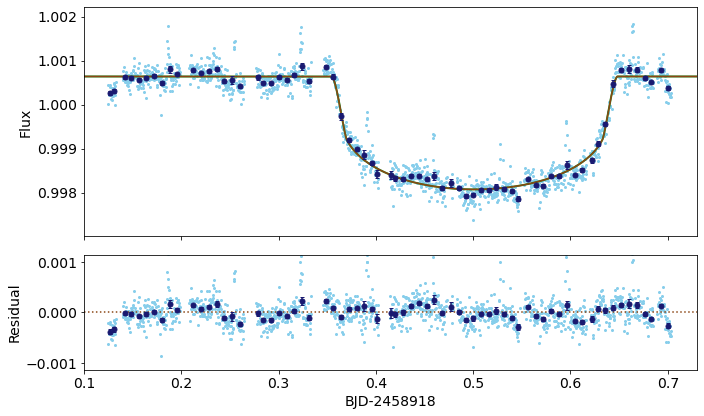

In [14]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14);

#### Prior for decorrelation parameters

Decorrelation is done against is a scaled version of the quantity specified with a range of either (-1,1) or, for strictly positive quantities, (0,1). This means the coefficients dfdx, dfdy, etc.
correspond to the amplitude of the flux variation due to the correlation with the relevant parameter.

A sensible prior for these coefficients (decorrelation parameters) is a normal distribution with the same standard deviation as the residuals from the fit above with no decorrelation. 

Careful selection of the prior is important because it will be used later to determine if we have selected a good set of decorrelation parameters.

In [15]:
sigma_0 = lmfit0.rms
dprior = ufloat(0, sigma_0)
print(f'sigma_0 = {sigma_0:0.6f}')

sigma_0 = 0.000251


In [16]:
lmfit = dataset.lmfit_transit(T_0 = (0.475,0.525), P=4.73609, 
                      D=(D_TESS/4, D_TESS, D_TESS*4),
                      W=(W_TESS/4, W_TESS, W_TESS*4),
                      b=(0,b_TESS,1), f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2.n,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      dfdsin2phi=dprior,dfdcos2phi=dprior,
                      dfdsin3phi=dprior,dfdcos3phi=dprior,
                      dfdt=dprior,
                      logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 207
    # data points      = 1446
    # variables        = 15
    chi-square         = 3242.54640
    reduced chi-square = 2.26593040
    Akaike info crit   = 1197.72861
    Bayesian info crit = 1276.87696
    RMS residual       = 241.3 ppm
[[Variables]]
    T_0:         0.50142037 +/- 0.00543502 (1.08%) (init = 0.5)
    P:           4.73609 (fixed)
    D:           0.00249254 +/- 3.3389e-05 (1.34%) (init = 0.00212521)
    W:           0.06218871 +/- 2.5019e-04 (0.40%) (init = 0.06194946)
    b:           0.73265782 +/- 0.00225305 (0.31%) (init = 0.43)
    f_c:        -0.03681476 +/- 0.30576913 (830.56%) (init = -0.02262488)
    f_s:         0.08900984 +/- 0.12853195 (144.40%) (init = 0.1753428)
    h_1:         0.72220497 +/- 0.01072669 (1.49%) (init = 0.715)
    h_2:         0.442 (fixed)
    c:           1.00063382 +/- 1.0749e-05 (0.00%) (init = 1)
    dfdt:        8.3350e-05 +/- 4.8372e-05 (58.04%) (init =

##### Model selection

The question of which decorrelation parameters to include is an example of model selection. In this case we have nested models in which one or more of the parameters is fixed in the simpler model.

For models $M_0$ and $M_1$ with parameters $\theta_0 = \{p_1, p_2, \dots, p_n, 0\}$ and $\theta_1 = \{p_1, p_2, \dots, p_n, \psi\}$, given the data $D$, the Bayes factor $B_{01}$ is defined by  

$$ \frac{P(M_0|D)}{P(M_1|D)} = \frac{P(M_0)}{P(M_1)} \frac{P(D|M_0)}{D|P(M_1)} = \frac{P(M_0)}{P(M_1)} B_{01},$$
where
$ P(D|M_0) = \int P(D|\theta_0)P(\theta_0)d^n\theta$ and similarly for $P(D|M_1)$. $P(\theta_0)$ is the prior on the parameters of model $M_0$.

The prior on the extra parameter are the same for both models so we can use the Savage-Dickey Density Ratio to calculate the Bayes factor
$$ B_{01} = \frac{P(\psi=0|D)}{P(\psi=0)} $$

For a normal prior with standard deviation $\sigma_0$, $P(\psi=0) = 1/\sigma_0\sqrt{2\pi}$.

The posterior probability distributions for the decorrelation parameters are normally well-behaved and close to Gaussian, as expected for a linear model. Assuming that they are normally distributed and that the standard deviation is given accurately by the error on the parameter given by lmfit, and that *a priori* the two models are equally likely, we can calculate Bayes factor for models with/without parameter with value $p\pm\sigma_p$ from lmfit using

$$B_p = e^{-(p/\sigma_p)^2/2}\sigma_0/\sigma_p$$

These are the values listed in the section \[\[Bayes Factors\]\] in the report above. Parameters with Bayes factors $\overset{>}{\sim} 1$  are not supported by the data and can be removed from the model. In this example we can safely remove dftdt. We could instead remove dfdsin2phi, but we will keep it because it is one of a set. 


**N.B.** this statistic is only valid for comparison of the models with/without one parameter, so parameters should be removed one-by-one and the test repeated for every new pair of models.



For a derivation of the Savage-Dickey Density Ratio see  Trotta [2007MNRAS.378...72T](https://ui.adsabs.harvard.edu/abs/2007MNRAS.378...72T/abstract)

#### Re-run lmfit without dfdt

In [17]:
lmfit = dataset.lmfit_transit(T_0 = (0.475,0.525), P=4.73609, 
                      D=(D_TESS/4, D_TESS, D_TESS*4),
                      W=(W_TESS/4, W_TESS, W_TESS*4),
                      b=(0,b_TESS,1), f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2.n,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      dfdsin2phi=dprior,dfdcos2phi=dprior,
                      dfdsin3phi=dprior,dfdcos3phi=dprior,
                      logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4150
    # data points      = 1445
    # variables        = 14
    chi-square         = 3163.91914
    reduced chi-square = 2.21098473
    Akaike info crit   = 1160.44964
    Bayesian info crit = 1234.31174
    RMS residual       = 238.7 ppm
[[Variables]]
    T_0:         0.50115677 +/- 0.03425640 (6.84%) (init = 0.5)
    P:           4.73609 (fixed)
    D:           0.00235062 +/- 4.1142e-05 (1.75%) (init = 0.00212521)
    W:           0.06183717 +/- 2.4726e-04 (0.40%) (init = 0.06194946)
    b:           0.64333809 +/- 0.02763038 (4.29%) (init = 0.43)
    f_c:        -0.03747351 +/- 0.27844658 (743.05%) (init = -0.02262488)
    f_s:         0.08602891 +/- 0.02383290 (27.70%) (init = 0.1753428)
    h_1:         0.70777666 +/- 0.00985956 (1.39%) (init = 0.715)
    h_2:         0.442 (fixed)
    c:           1.00062710 +/- 9.4446e-06 (0.00%) (init = 1)
    dfdsinphi:   3.3629e-05 +/- 1.0128e-05 (30.12%) (init =

#### Plots of least-squares fit  after de-trending the data 
In this plot (detrend=True) 
- (flux/trend) values are light blue points
- binned (flux/trend) values are dark blue error bars
- transit model is the green line
- transit model/trend is the brown line (same as green line in this case) 

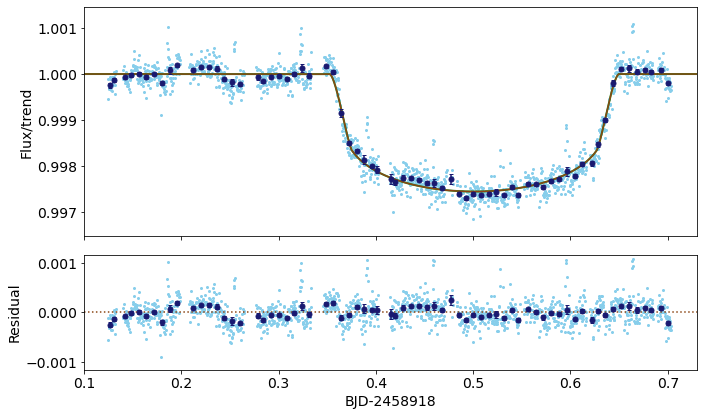

In [18]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True);

#### Roll angle plot
Same color-coding of data and models as before. You can see the gap we produced with dataset.mask_data earlier.

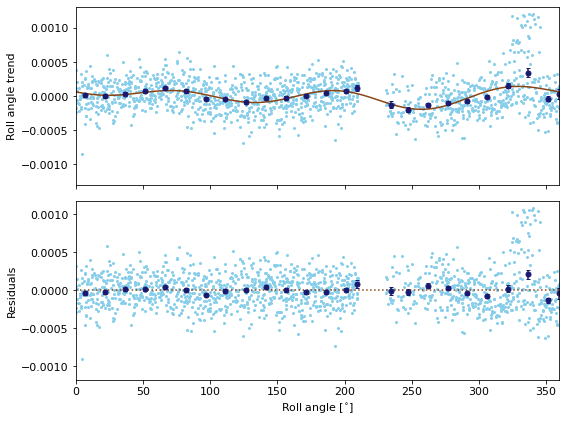

In [19]:
fig = dataset.rollangle_plot()

#### Try modelling excess flux near roll angle 340$^{\circ}$ as internal reflection ("glint")

The method `add_glint()` is being used here to calculate a spline fit to the residuals from the last fit. A scaled version of this function (which is stored in dataset) can then be added to the model. 

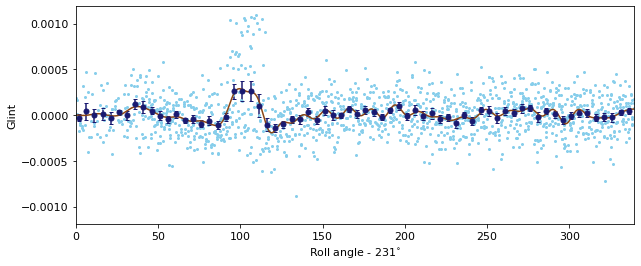

In [20]:
glint_func = dataset.add_glint(nspline=48,binwidth=5,figsize=(10,4),gapmax=5)

#### Fit including glint
The parameter glint_scale includes a linear scaling of the glint function we created as part of the model. Here we allow the glint to be scaled between 0 (no glint) and 2 (twice as much glint as estimated from the previous fit).

In [21]:
dataset.lmfit_transit(T_0 = (0.4,0.6), P=4.73609, 
                      D=(D_TESS/4,D_TESS,D_TESS*4),
                      W=(W_TESS/4,W_TESS,W_TESS*4),
                      b=(0,b_TESS,1),
                      dfdcontam=dprior,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      dfdsin2phi=dprior,dfdcos2phi=dprior,
                      dfdsin3phi=dprior,dfdcos3phi=dprior,
                      glint_scale=(0,2),
                      f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2,logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 570
    # data points      = 1447
    # variables        = 17
    chi-square         = 2817.00317
    reduced chi-square = 1.96993229
    Akaike info crit   = 997.964148
    Bayesian info crit = 1087.67736
    RMS residual       = 224.9 ppm
[[Variables]]
    T_0:          0.50133346 +/- 0.00346858 (0.69%) (init = 0.5)
    P:            4.73609 (fixed)
    D:            0.00215166 +/- 4.8201e-05 (2.24%) (init = 0.00212521)
    W:            0.06251851 +/- 0.00214104 (3.42%) (init = 0.06194946)
    b:            0.44425790 +/- 0.07041259 (15.85%) (init = 0.43)
    f_c:         -0.02327001 +/- 0.18483374 (794.30%) (init = -0.02262488)
    f_s:          0.16470725 +/- 0.13548504 (82.26%) (init = 0.1753428)
    h_1:          0.69439872 +/- 0.00851026 (1.23%) (init = 0.715)
    h_2:          0.46199120 +/- 0.06586487 (14.26%) (init = 0.442)
    c:            1.00066419 +/- 3.8922e-05 (0.00%) (init = 1)
    dfdcontam

#### Plot the results


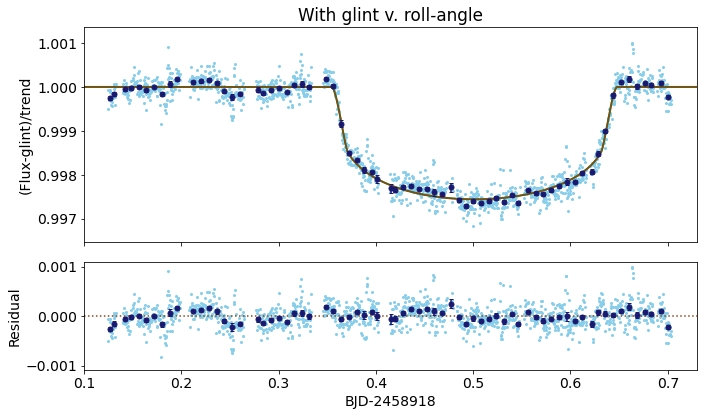

In [22]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
                   title='With glint v. roll-angle');

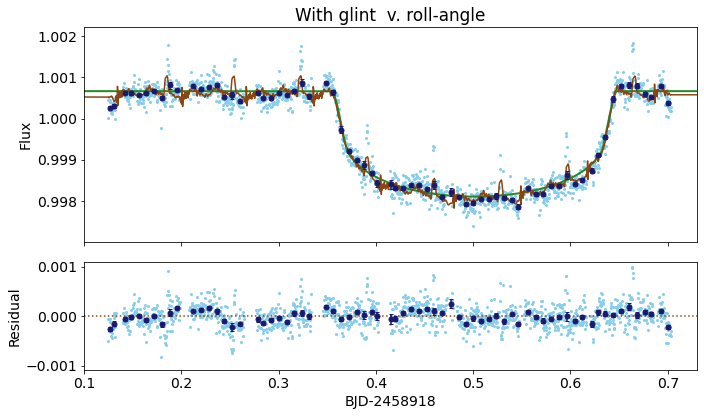

In [23]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=False,
                   title='With glint  v. roll-angle');

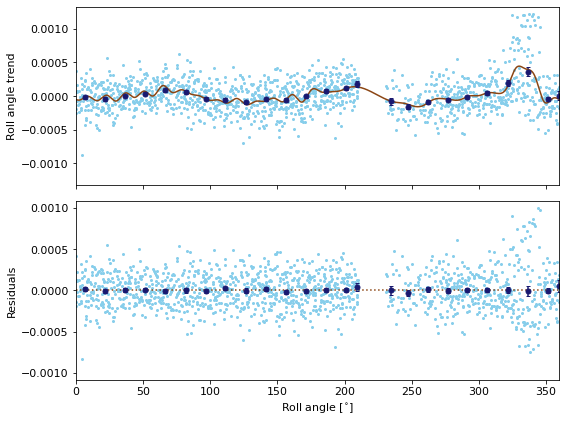

In [24]:
fig = dataset.rollangle_plot()

##### Glint correction for internal reflection from the Moon.
The previous fit is better, but the extra flux does not appear at exactly the same roll angle every time. The reason from this can be found by checking for solar system objects near the field of view. We see that the Moon was only 16$^{\circ}$ from the target. The position of the Moon varies noticeably during the observation, so we must account for this when we model the glint.

In [25]:
dataset.planet_check()

BJD = 2458918.124880498
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     11:21:44.78  +09:19:29.6      16.0
Mars     19:05:24.57  -23:08:38.0      81.6
Jupiter  19:29:58.33  -21:50:58.1     113.6
Saturn   20:03:17.21  -20:27:01.5     125.8
Uranus   02:06:47.07  +12:20:30.2     129.0
Neptune  23:18:02.79  -05:36:58.0     163.1


#### Try modelling excess flux near roll angle 340 as Moon glint

Residuals from last fit will already be corrected for glint, so we can either re-run lmfit without `glint_scale` and re-fit, or just fit the out-of transit flux. 

For this example, let's create a mask so that we can fit the out-of-transit flux.


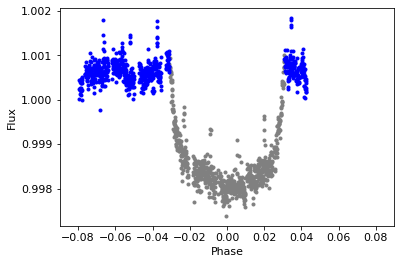

In [26]:
phase = (((time-lmfit.params['T_0'])/lmfit.params['P'] + 0.5) % 1) - 0.5 # Phase range -0.5 .. 0.5
mask = abs(phase) < lmfit.params['W']/2
plot(phase[mask],flux[mask],'.',color='gray')
plot(phase[~mask],flux[~mask],'.',color='blue')
xlim(-0.09,0.09)
xlabel('Phase')
ylabel('Flux');

##### Creating glint function v. moon angle
- using fit_flux to fit flux values, not residuals
- using mask=mask to use mask created above to exclude in-transit data
- using moon=True to account for motion of the Moon

The previous glint function is overwritten by this new glint function.

Note the the spike v. Moon angle is sharper than against roll angle.

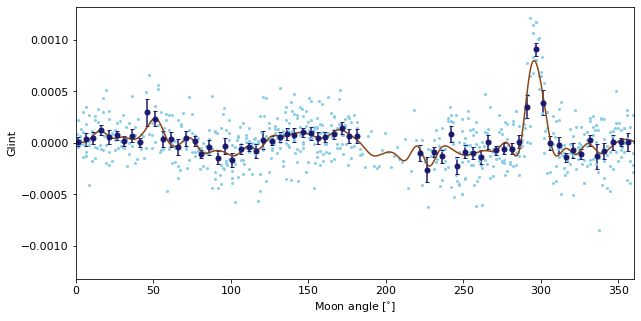

In [27]:
moon_glint = dataset.add_glint(moon=True,nspline=48,binwidth=5,
                               fit_flux=True, mask=mask,
                              figsize=(10,5))

##### Least-squares fit including glint v. moon angle

In [28]:
dataset.lmfit_transit(T_0 = (0.4,0.6), P=4.73609, 
                      D=(D_TESS/4,D_TESS,D_TESS*4),
                      W=(W_TESS/4,W_TESS,W_TESS*4),
                      b=(0,b_TESS,1),
                      f_c=f_c, f_s=f_s,
                      dfdcontam=dprior,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      dfdsin2phi=dprior,dfdcos2phi=dprior,
                      dfdsin3phi=dprior,dfdcos3phi=dprior,
                      glint_scale=(0,2),
                      h_1=star.h_1, h_2=star.h_2,logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 481
    # data points      = 1447
    # variables        = 17
    chi-square         = 2418.87261
    reduced chi-square = 1.69151931
    Akaike info crit   = 777.481796
    Bayesian info crit = 867.195008
    RMS residual       = 207.9 ppm
[[Variables]]
    T_0:          0.50143085 +/- 0.00197414 (0.39%) (init = 0.5)
    P:            4.73609 (fixed)
    D:            0.00214697 +/- 4.5171e-05 (2.10%) (init = 0.00212521)
    W:            0.06240229 +/- 2.4285e-04 (0.39%) (init = 0.06194946)
    b:            0.44831911 +/- 0.06635674 (14.80%) (init = 0.43)
    f_c:         -0.02281936 +/- 0.17400651 (762.54%) (init = -0.02262488)
    f_s:          0.15291839 +/- 0.00262451 (1.72%) (init = 0.1753428)
    h_1:          0.69286324 +/- 0.00788345 (1.14%) (init = 0.715)
    h_2:          0.46924783 +/- 0.06086985 (12.97%) (init = 0.442)
    c:            1.00057871 +/- 3.6417e-05 (0.00%) (init = 1)
    dfdcontam:

#### Simplify model
 The previous lmfit shows that we can simplify the model by removing one of the free parameters with a large Bayes factors. Doing this one-by-one shows that the glint function by itself is sufficient to remove the trends in the data so the final model is quite simple. 

In [29]:
dataset.lmfit_transit(T_0 = (0.4,0.6), P=4.73609, 
                      D=(D_TESS/4,D_TESS,D_TESS*4),
                      W=(W_TESS/4,W_TESS,W_TESS*4),
                      b=(0,b_TESS,1),
                      f_c=f_c, f_s=f_s,
                      glint_scale=(0,2),
                      h_1=star.h_1, h_2=star.h_2,logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 262
    # data points      = 1440
    # variables        = 10
    chi-square         = 2453.14807
    reduced chi-square = 1.71548816
    Akaike info crit   = 787.129778
    Bayesian info crit = 839.853762
    RMS residual       = 209.3 ppm
[[Variables]]
    T_0:          0.50144182 +/- 0.00177960 (0.35%) (init = 0.5)
    P:            4.73609 (fixed)
    D:            0.00215085 +/- 4.8563e-05 (2.26%) (init = 0.00212521)
    W:            0.06239149 +/- 0.00224775 (3.60%) (init = 0.06194946)
    b:            0.45289374 +/- 0.06762269 (14.93%) (init = 0.43)
    f_c:         -0.02331297 +/- 0.01456209 (62.46%) (init = -0.02262488)
    f_s:          0.14610568 +/- 0.16795787 (114.96%) (init = 0.1753428)
    h_1:          0.69106341 +/- 0.00778501 (1.13%) (init = 0.715)
    h_2:          0.46348226 +/- 0.06106716 (13.18%) (init = 0.442)
    c:            1.00062340 +/- 8.0431e-06 (0.00%) (init = 1)
    glint_sca

##### Plot the results.

Note that for the roll angle plot there are now 3 panels. The residuals in the top panel are corrected for glint but not for other trends - the model for these is shown in brown. The fit of the glint function to the residuals corrected for other trends is shown the middle panel. The lower panel shows the residuals from the complete model, i.e., flux - (transit $\times$ trends + glint)

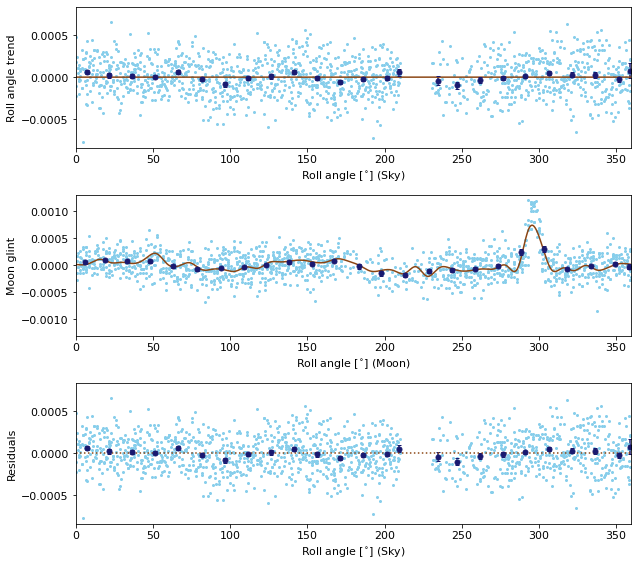

In [30]:
fig = dataset.rollangle_plot()

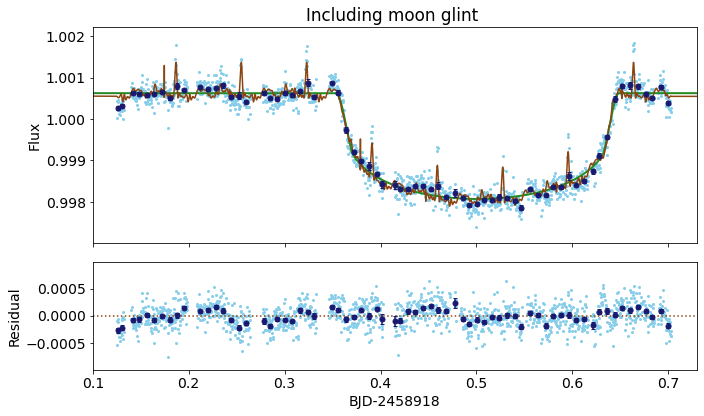

In [31]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=False,
                  title='Including moon glint ');

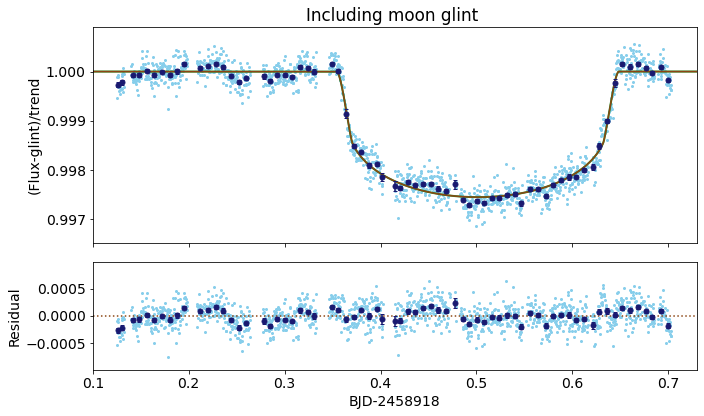

In [32]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
                  title='Including moon glint ');

#### GP fit with fixed transit parameters

The "bumps-and-wiggles" in the residuals from the previous fit are very likely to be due to real flux variations from the star due to convection in its atmosphere a.k.a. granulation noise or "flicker". The time scale ($\sim$ hour) and amplitude ($\sim 100$ppm) of the variation are typical granulation noise observed in other cool sub-giant stars. 

A Gaussian Process (GP) is a way to model the granulation noise by specifying the properties of the correlation matrix for this correlated noise. We will use the [`celerite`](https://celerite.readthedocs.io/en/stable/) package to do this because it can do the calculation of the likelihood for a given noise function very quickly, and it includes a kernel that is appropriate for granulation noise. 


Our noise model will then have three components
- Gaussian white noise with standard deviation per-point given by `flux_err`.
- Extra Gaussian white noise ("jitter") with standard deviation per-point $\sigma$
- Correlated noise described by a GP calculated using the [SHOTerm](https://celerite.readthedocs.io/en/stable/python/kernel/?highlight=shoterm#celerite.terms.SHOTerm) kernel in celerite with fixed shape parameter $Q=1/\sqrt{2}$.

With $Q=1/\sqrt{2}$, the kernel that describes the covariance between observations separated by a time $\tau$ is 
$$ k(\tau) = S_0\omega_0 e^{-\omega_0\tau/\sqrt{2}}\cos\left(\omega_0\tau/\sqrt{2} - \pi/4\right)$$

The free parameters of the noise model are then $\sigma$ (amplitude of the jitter), $\omega_0$ (related to correlation time scale) and $S_0$ (related to amplitude of the correlated noise). These are all strictly positive values for which we want to use a scale-free prior so we use the log of these values when we sample the posterior probability distribution (PPD). The sampling of the PPD is done using [emcee](https://emcee.readthedocs.io/en/stable/).


Directly fitting a GP to the data with all the transit and decorrelation parameters as free parameters leads to large errors on the transit parameters and a GP that implies much more variability in the flux than is seen in CHEOPS data for similar stars, i.e., the GP tries to model the transit as noise. To avoid this, we first do a GP fit with the transit parameters fixed. The results from this fit are used to put priors on the parameters of the noise model in the final fit.


In [33]:
# Copy the parameters from the last lmfit
params_fixed = dataset.lmfit.params.copy() 

# Fix the transit parameters
for p in ['T_0','D','W','b']:
    params_fixed[p].set(vary=False)

# Use emcee to sample the PPD. Note we add the SHOTerm at this step.
result = dataset.emcee_sampler(params=params_fixed, add_shoterm=True, burn=1024,steps=512,nwalkers=64)

print(dataset.emcee_report(min_correl=0.5))


Running burn-in ..


100%|██████████| 1024/1024 [06:21<00:00,  2.68it/s]

Running sampler ..



100%|██████████| 2048/2048 [13:20<00:00,  2.56it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 131072
    # data points      = 1435
    # variables        = 9
    chi-square         = 2460.60384
    reduced chi-square = 1.72552864
    Akaike info crit   = -20531.6622
    Bayesian info crit = -20484.2419
    RMS residual       = 209.8 ppm
[[Variables]]
    T_0:          0.5014418 (fixed)
    P:            4.73609 (fixed)
    D:            0.002150852 (fixed)
    W:            0.06239149 (fixed)
    b:            0.4528937 (fixed)
    f_c:         -0.02260157 +/- 0.20702308 (915.97%) (init = -0.02262488)
    f_s:          0.09801307 +/- 0.04833113 (49.31%) (init = 0.1753428)
    h_1:          0.70842812 +/- 0.01036927 (1.46%) (init = 0.715)
    h_2:          0.45707874 +/- 0.04789824 (10.48%) (init = 0.442)
    c:            1.00061966 +/- 1.7887e-05 (0.00%) (init = 1)
    glint_scale:  0.95619115 +/- 0.04183798 (4.38%) (init = 1)
    k:            0.04637728 +/- 5.2356e-04 (1.13%) == 'sqrt(D)'
    aR:     

##### Plot of emcee fit including a GP noise model - no de-trending
With detrend=False (the default) the upper panel shows the unbinned and binned flux values used in the fit (light blue and dark blue, as before), the transit model (green) and the best-fit (maximum likelihood) model including all trends, glint and the GP noise model. Several samples from the PPD are used to plot other models that give a reasonable fit to the data in light brown. 

The lower panel shows the residuals from non-GP parts of the model, i.e., flux - (transit $\times$ trends + glint). The GP noise model is shown in brown.

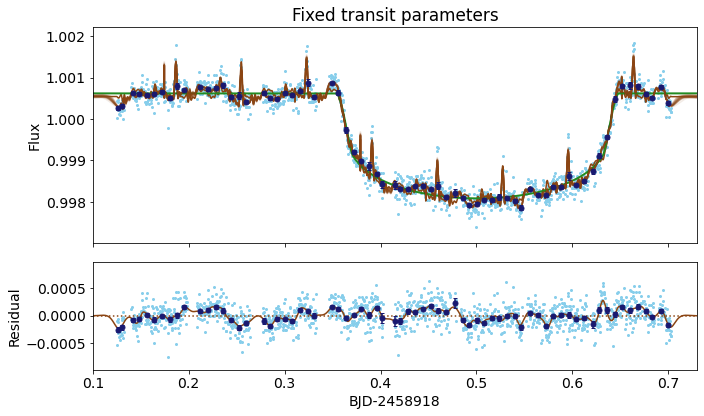

In [34]:
fig  = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14,
                          title='Fixed transit parameters')

##### Plot of emcee fit including a GP noise model - with de-trending
With detrend=True, the flux values in the upper panel have been corrected for instrumental trends and glint. The transit model is shown in green, and the transit model + GP noise models are shown in brown (best-fit and samples, as before). The residuals are plotted in the lower panel in the same way as for detrend=False.

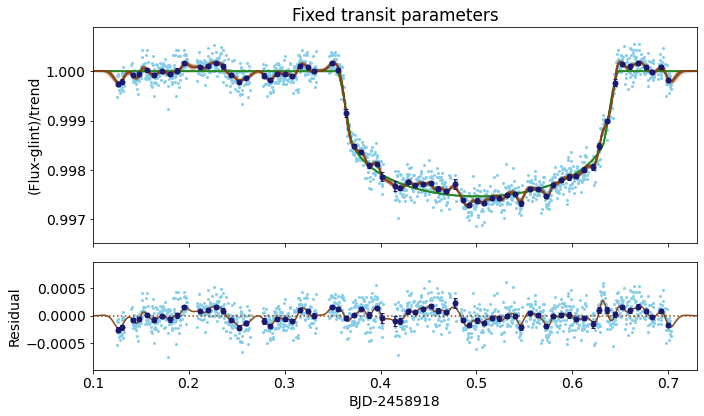

In [35]:
fig = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
                          title='Fixed transit parameters')

#### Complete emcee sampler run with priors  

We now create Gaussian priors on the noise model parameters centered on the mean of the PPD from the previous fit, and the standard deviation is set to twice the width the PPD. This keeps the noise model in a reasonable region of its parameter space while allowing us to explore if the transit model parameters depend strongly on the noise model. This is done by setting the user_data attribute of the [lmfit Parameter object](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter) to a [ufloat](https://pythonhosted.org/uncertainties/) value.

We already added the SHOTerm to the model in the previous step so we do not need to include "add_shoterm" in the call to emcee_sampler again. The output from this emcee run will overwrite the previous results stored in the dataset object. We are also over-writing the "result" variable that stores the output from the previous emcee run as an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult) object - we could give the result a different variable name here if we want to save those results.


In [36]:
# Get a copy of the parameters from the previous emcee run
params_prior = dataset.emcee.params.copy()

# Setting the noise model parameters
from uncertainties import ufloat
for p in ['log_S0', 'log_omega0', 'log_sigma']:
    params_prior[p].user_data=ufloat(params_prior[p].value,2*params_prior[p].stderr)

# Restoring the transit model parameters as free parameters
for p in ['T_0','D','W','b']:
    params_prior[p].set(vary=True)
    
# Run emcee again
result = dataset.emcee_sampler(params=params_prior, burn=512, steps=256, nwalkers=64)
print(dataset.emcee_report(min_correl=0.5))

Running burn-in ..


100%|██████████| 512/512 [03:18<00:00,  2.58it/s]

Running sampler ..



100%|██████████| 1024/1024 [06:28<00:00,  2.64it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 65536
    # data points      = 1435
    # variables        = 13
    chi-square         = 2488.40994
    reduced chi-square = 1.74993667
    Akaike info crit   = -20526.8722
    Bayesian info crit = -20458.3762
    RMS residual       = 211.0 ppm
[[Variables]]
    T_0:          0.50211653 +/- 6.1939e-04 (0.12%) (init = 0.5)
    P:            4.73609 (fixed)
    D:            0.00206802 +/- 6.4342e-05 (3.11%) (init = 0.00212521)
    W:            0.06346722 +/- 0.00245050 (3.86%) (init = 0.06194946)
    b:            0.25547162 +/- 0.15261798 (59.74%) (init = 0.43)
    f_c:          0.00596431 +/- 0.24402675 (4091.45%) (init = -0.02262488)
    f_s:          0.14364176 +/- 0.12161103 (84.66%) (init = 0.1753428)
    h_1:          0.70978233 +/- 0.01027584 (1.45%) (init = 0.715)
    h_2:          0.45723977 +/- 0.04588298 (10.03%) (init = 0.442)
    c:            1.00061801 +/- 2.8425e-05 (0.00%) (init = 1)
    glint_

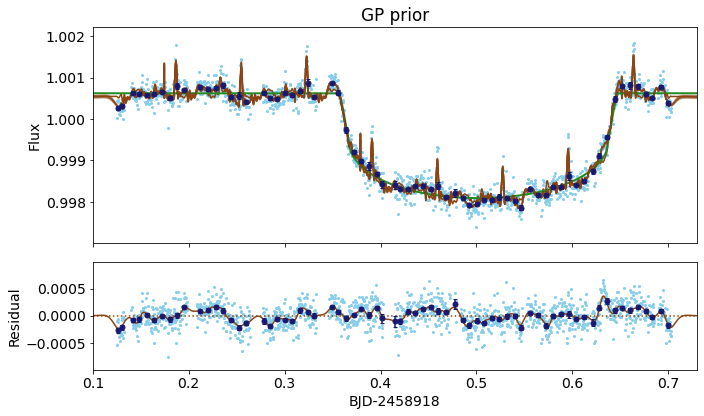

In [37]:
fig  = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=False,
                          title='GP prior')

#### Here we save a the plot of the final fit to the light curve as a file

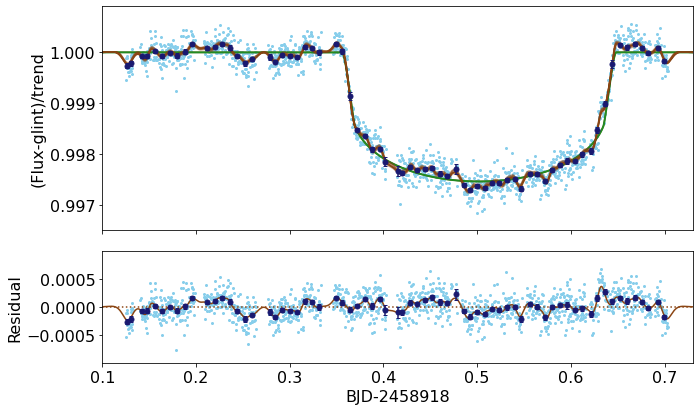

In [38]:
fig  = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=16, detrend=True)
fig.savefig('kelt11fig.png')

#### Corner plots
We can use a corner plot to view correlations between model parameters. Gaussian priors on parameters are shown using dashed-green lines to indicate the $\pm$ 1-sigma limits. In this first corner plot we can see how the PPD of the noise model parameters are narrower than their priors, i.e., the noise models are still being determined mostly by the data and the priors are only preventing these parameters from going to very large or small values.  

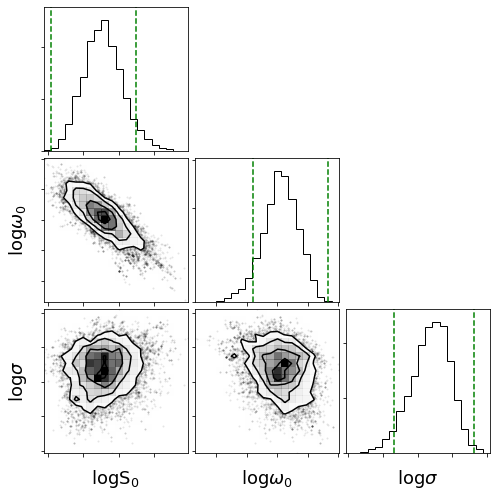

In [39]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 18}
fig = dataset.corner_plot(plotkeys=['log_S0','log_omega0','log_sigma'],kwargs={'label_kwargs':{'fontdict':font}})

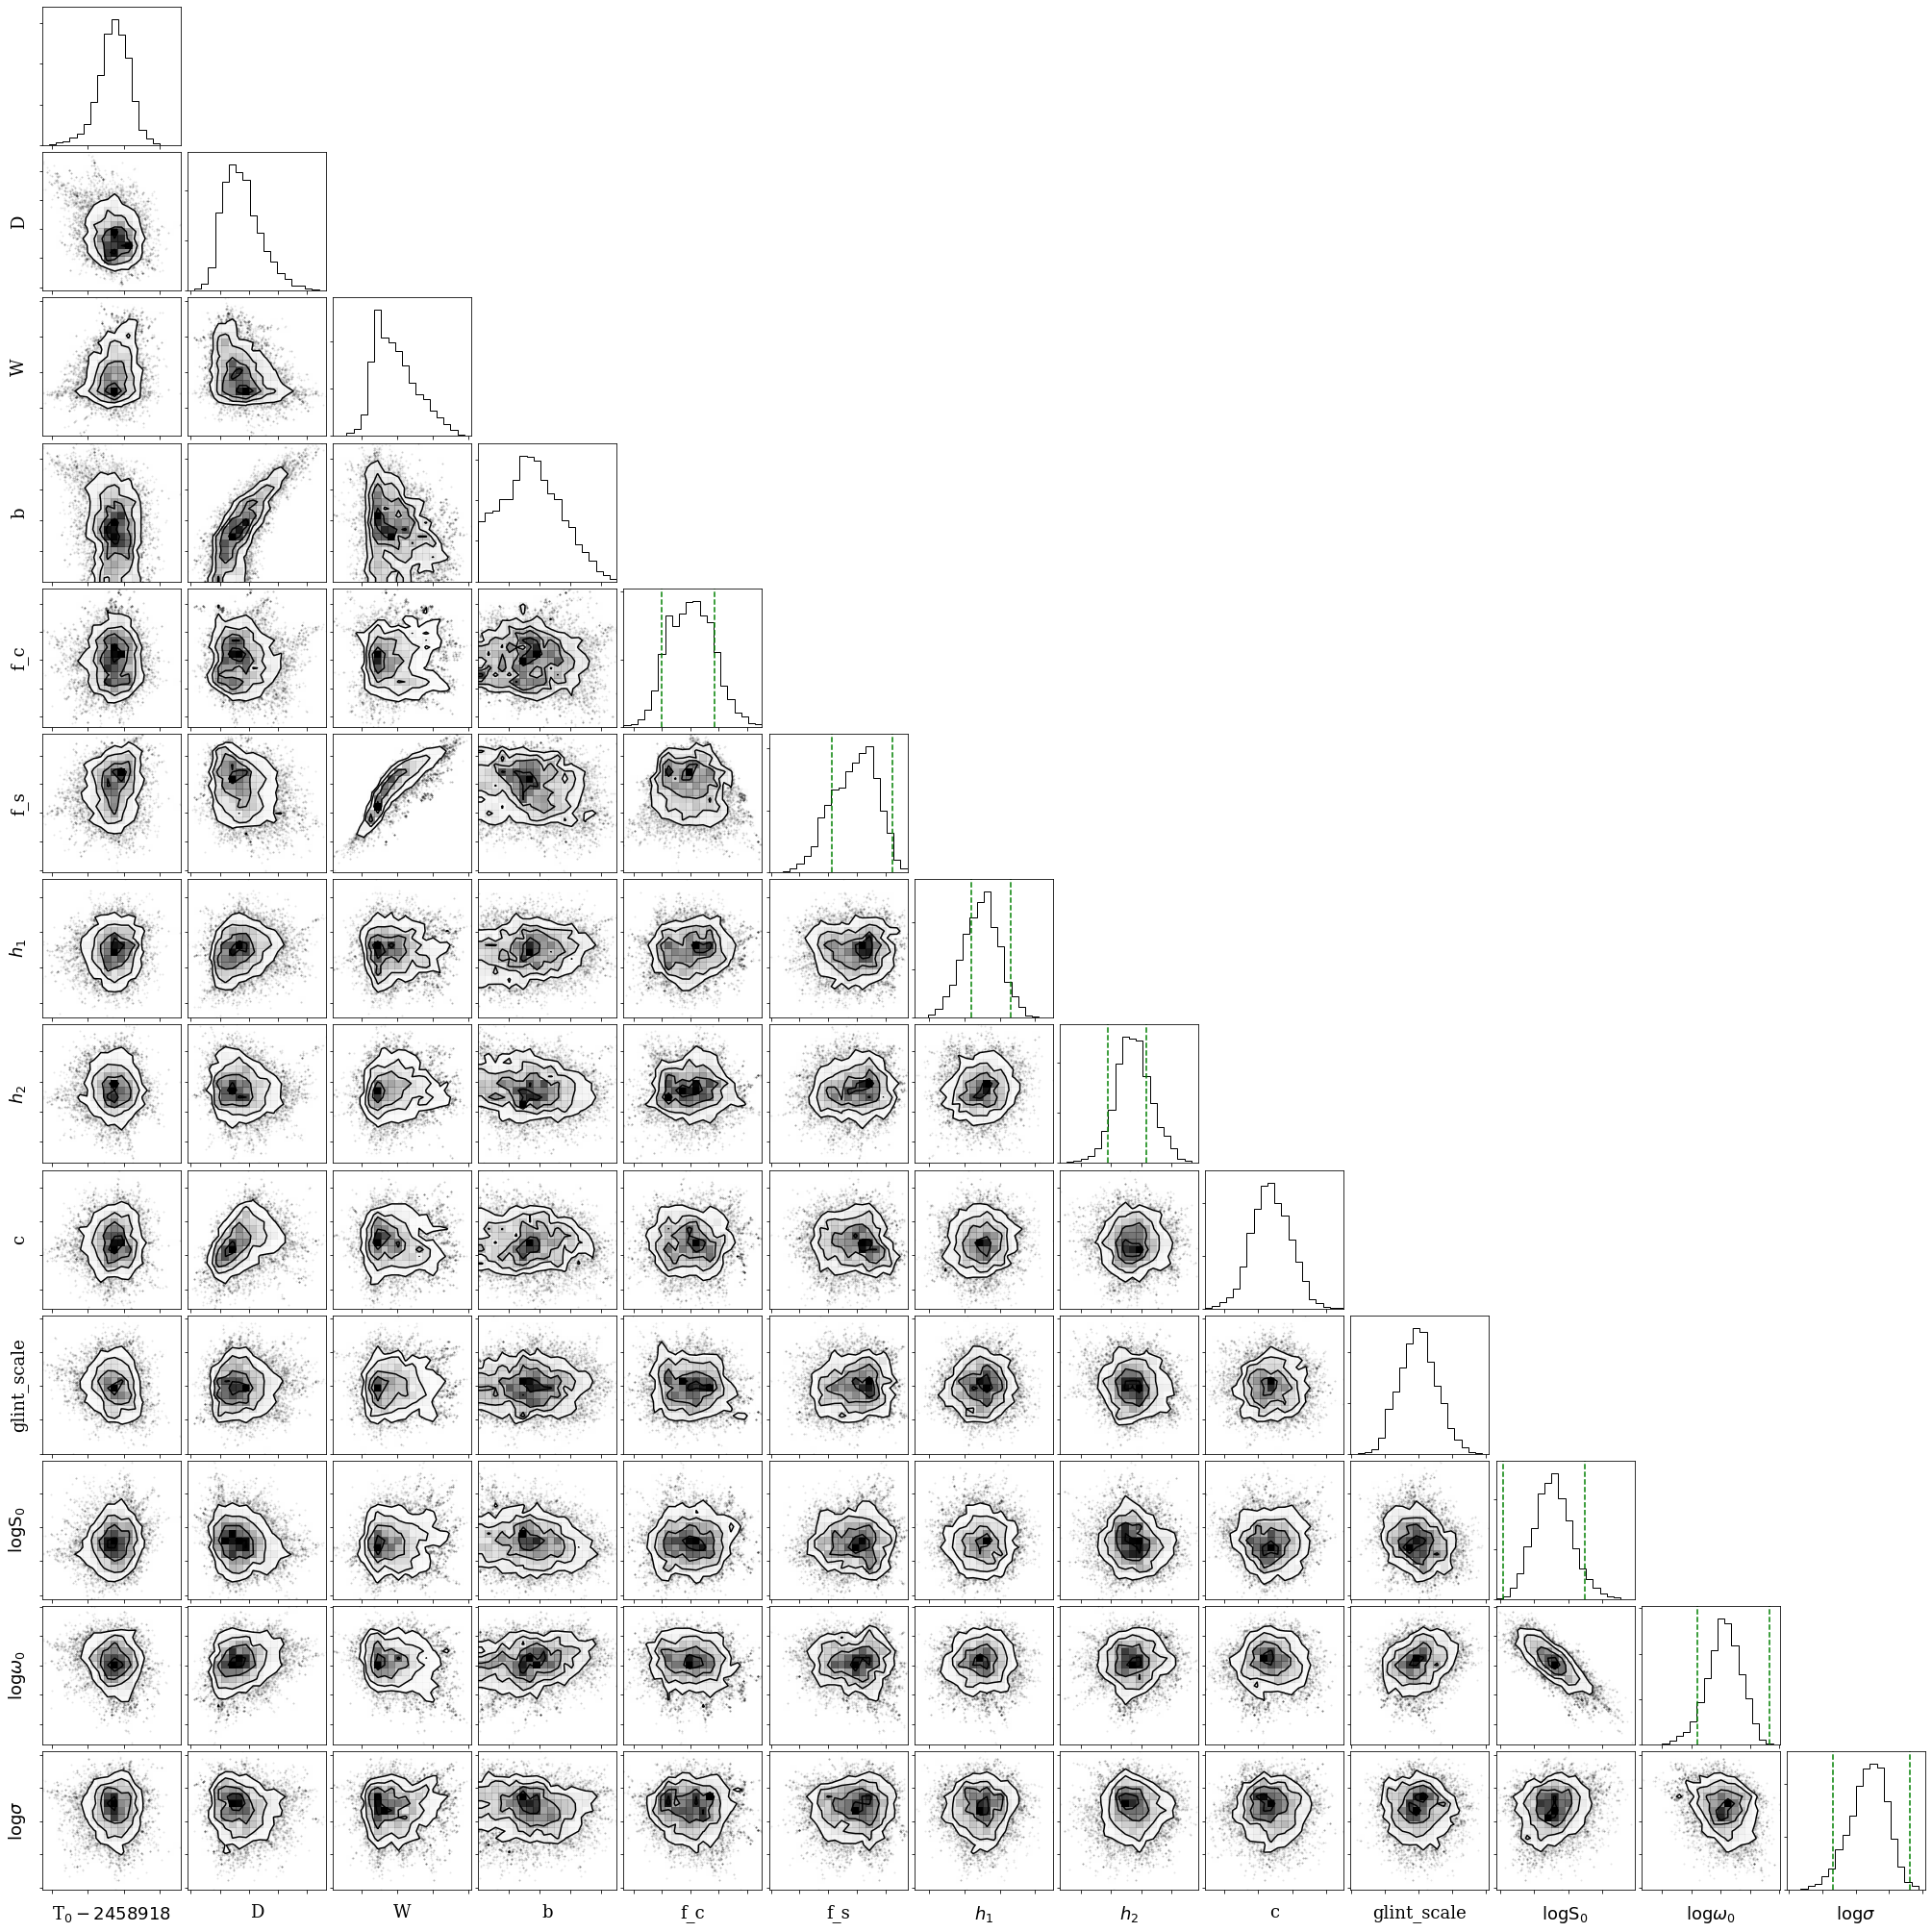

In [40]:
fig = dataset.corner_plot(plotkeys='all',kwargs={'label_kwargs':{'fontdict':font}})

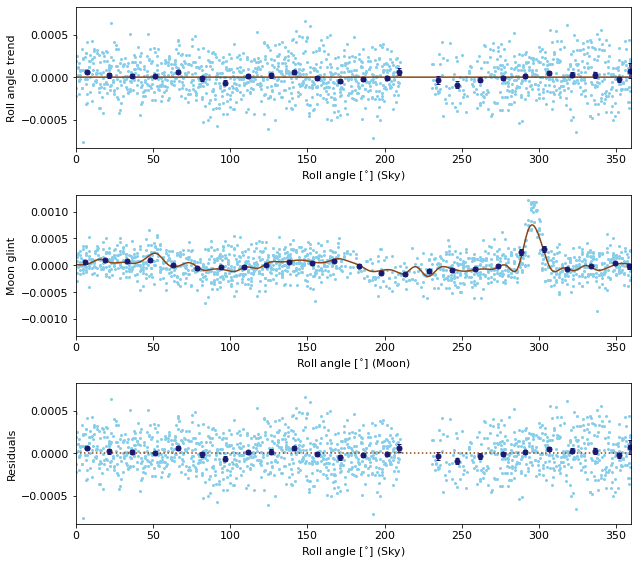

In [41]:
fig = dataset.rollangle_plot()

#### Trail plot
A trail plot is shows the parameter values v. step number for all the walkers in the sampler. This is a very effective way to check that the sampler has converged, i.e., that the sampler is randomly sampling the posterior probability distribution. 

In a "well-mixed" chain, the trail plot will look like noise for all the walkers and there will be no trends in the position or width of the trails.

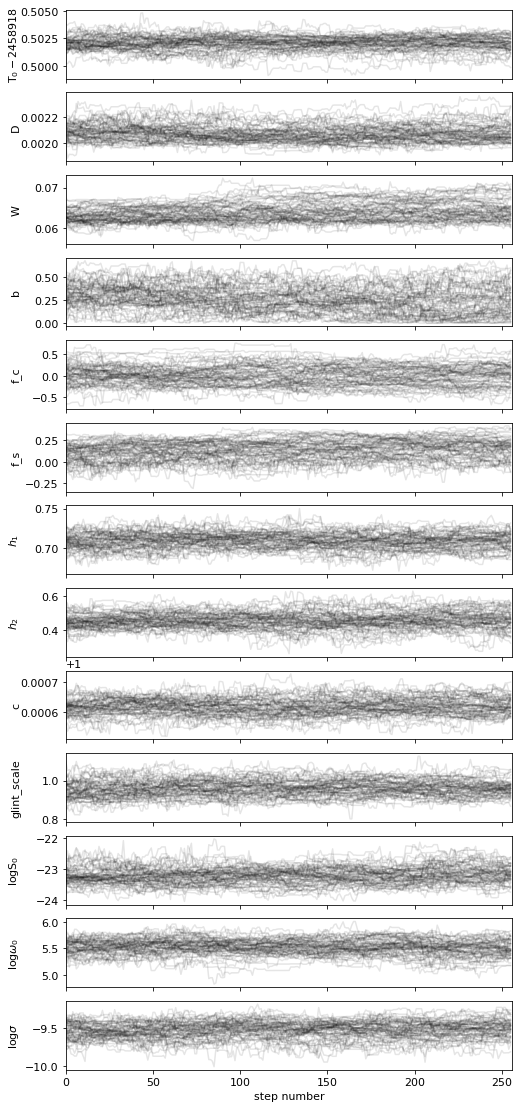

In [42]:
fig = dataset.trail_plot('all')

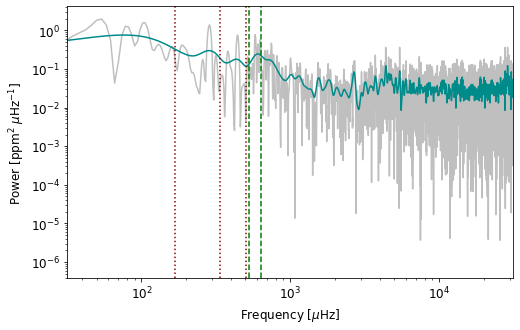

In [43]:
fig = dataset.plot_fft(star, gsmooth=10)

### Mass-radius plot
Once we are happy with the fit to the transit light curve we can use the parameters derived to calculate the mass and radius of the planet. To do this we need to specify the semi-amplitude of the star's orbit due to the planet (K in m/s) and provide the star's mass and/or radius. If only the mass is provided then the radius is calculated from the stellar density obtained from the transit width, and vice versa. 

For more details on the options in dataset.massradius, see the inline help for `pycheops.funcs.massradius`.


[[Mass/radius]]
    m_star   =      1.440 +/-      0.060 (    -0.060,    +0.060) M_Sun
    r_star   =       2.68 +/-       0.13 (     -0.13,     +0.14) R_Sun
    e        =      0.070 +/-      0.062 (    -0.049,    +0.075)
    r_p      =      13.30 +/-       0.77 (     -0.69,     +0.85) R_Earth
    m_p      =       61.6 +/-        6.0 (      -5.9,      +6.0) M_Earth
    q        =   0.000129 +/-   0.000012 ( -0.000012, +0.000012)
    a        =      13.40 +/-       0.19 (     -0.19,     +0.18) R_Sun
    a        =    0.06233 +/-    0.00086 (  -0.00088,  +0.00085) au
    rho_star =      0.075 +/-      0.011 (    -0.010,    +0.011) rho_Sun
    g_p      =       3.40 +/-       0.49 (     -0.48,     +0.50) m.s-2
    log g_p  =      2.532 +/-      0.063 (    -0.067,    +0.060) [cgs]
    rho_p    =     0.0261 +/-     0.0050 (   -0.0048,   +0.0052) rho_Earth
    rho_p    =      0.144 +/-      0.027 (    -0.026,    +0.028) [g.cm-3]


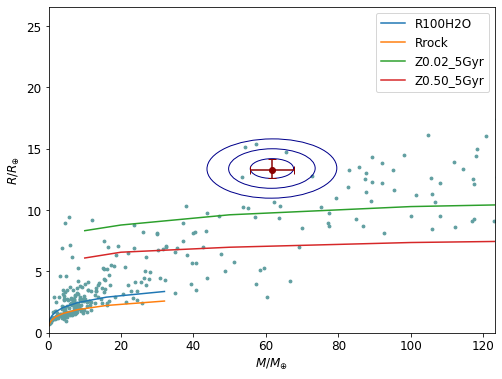

In [44]:
r,fig=dataset.massradius(m_star=(1.44, 0.06), K=(18.5,1.7),jovian=False)
fig.savefig('KELT-11b_massradius.png')

In [45]:
dataset.save();